### Import all the relevant packages

In [3]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import chart_studio.plotly  as py
from chart_studio.plotly import iplot
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet import ResNet50, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input


from keras import layers
from keras.models import Model,Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

## Define useful functions

In [4]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)    


def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1
        

def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-16 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

## Data Preparation
### This section includes three steps
#### 1. Define the path of images
#### 2. Split the images into train, test, and validate sets
#### 3. Save the splitted images into each folders

In [42]:
RANDOM_SEED = 1234
#For MAC or Linus
IMG_PATH = '/home/jerry/ghworkspace/machine_learning/Final Project/brain_tumor_dataset/'
dest='/home/jerry/ghworkspace/machine_learning/Final Project/dest/'


#For windows
# IMG_PATH = 'D:\\UCF Coursework\\ML Project\\Program\\brain_tumor_dataset\\'
# dest = 'D:\\UCF Coursework\\ML Project\\Program\\dset\\'model.add(base_model)

In [43]:

## Making Directory
os.mkdir(dest+'TRAIN/')
os.mkdir(dest+'TRAIN/YES')
os.mkdir(dest+'TRAIN/NO')

os.mkdir(dest+'VAL')
os.mkdir(dest+'VAL/YES')
os.mkdir(dest+'VAL/NO')

os.mkdir(dest+'TEST')
os.mkdir(dest+'TEST/YES')
os.mkdir(dest+'TEST/NO')

# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, dest+'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, dest+'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, dest+'VAL/'+ CLASS.upper() + '/' + FILE_NAME)




In [44]:
# For windows
# TRAIN_DIR = dest+'TRAIN\\'
# TEST_DIR =  dest+'TEST\\'
# VAL_DIR =  dest+'VAL\\'

#For MAC or Linux
TRAIN_DIR = dest+'TRAIN/'
TEST_DIR =  dest+'TEST/'
VAL_DIR =  dest+'VAL/'



In [45]:
IMG_SIZE = (224,224) #Size of VGG-16

100%|██████████| 2/2 [00:00<00:00,  6.02it/s]
<ipython-input-4-7cfcc2768e4c>:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

100%|██████████| 2/2 [00:00<00:00, 21.51it/s]


193 images loaded from /home/jerry/ghworkspace/machine_learning/Final Project/dest/TRAIN/ directory.
10 images loaded from /home/jerry/ghworkspace/machine_learning/Final Project/dest/TEST/ directory.
50 images loaded from /home/jerry/ghworkspace/machine_learning/Final Project/dest/VAL/ directory.


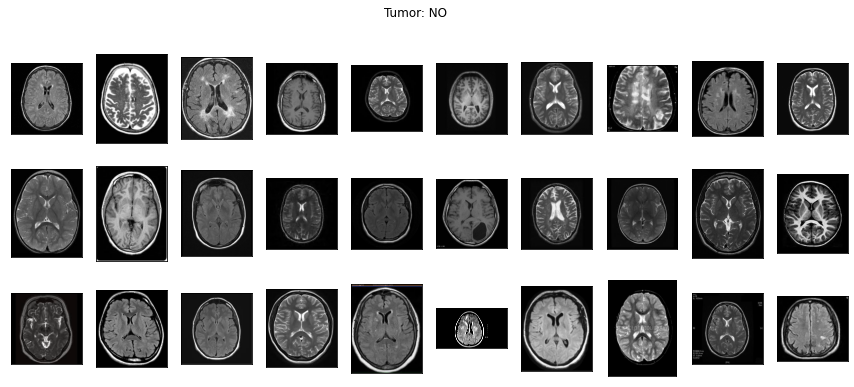

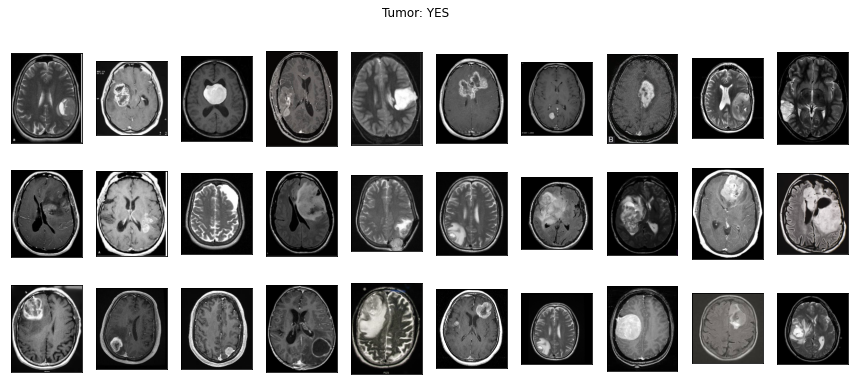

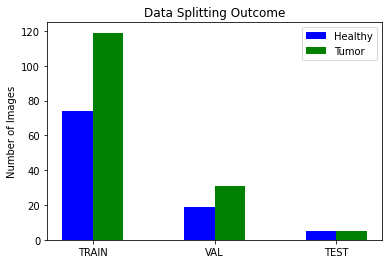

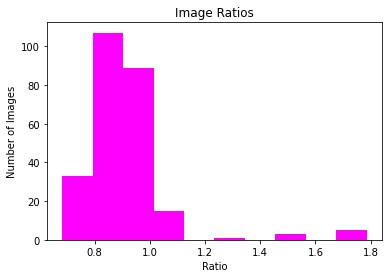

<ipython-input-4-7cfcc2768e4c>:102: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



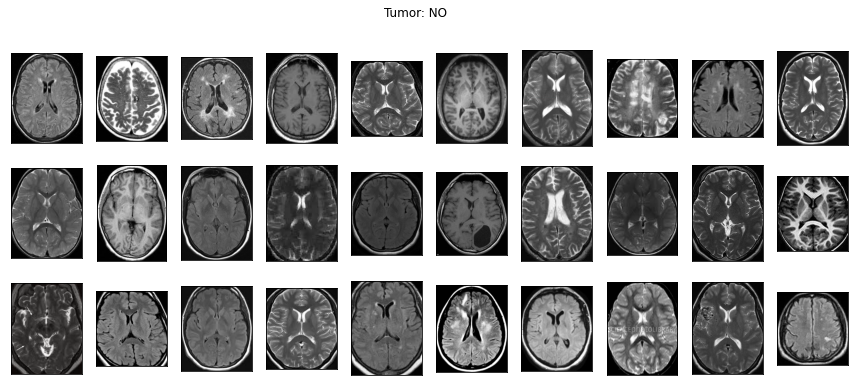

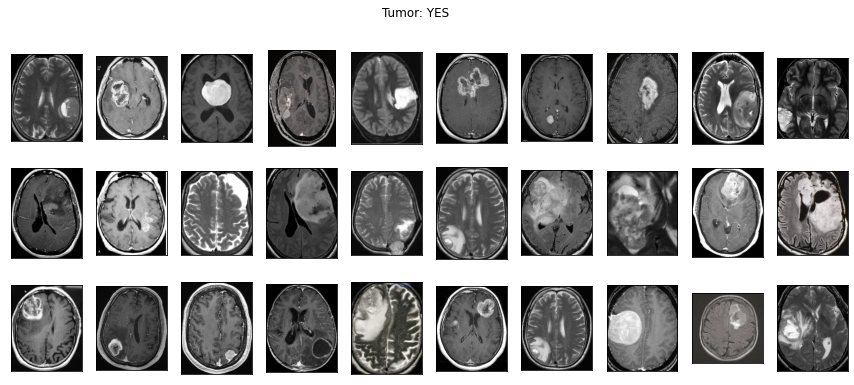

In [46]:
# load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

plot_samples(X_train, y_train, labels, 30)


## Histogram of data

y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

data = [y[0],y[1]]
X_bar = np.arange(3)
fig, ax = plt.subplots()
# ax = fig.add_axes([0,0,1,1])
ax.bar(X_bar + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X_bar + 0.25, data[1], color = 'g', width = 0.25)

ax.set_ylabel('Number of Images')
ax.set_title('Data Splitting Outcome')
plt.xticks(X_bar+0.125, ( 'TRAIN', 'VAL', 'TEST'))
ax.legend(labels=['Healthy', 'Tumor'])
plt.show()


## Histogram of image width

RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST,color='magenta')
plt.title('Image Ratios')
plt.xlabel('Ratio')
plt.ylabel('Number of Images')
plt.show()


X_train_prep = preprocess_imgs(set_name=X_train, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val, img_size=IMG_SIZE)


# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

plot_samples(X_train_crop, y_train, labels, 30)


TC=TRAIN_DIR+'TRAIN_CROP'
TC_Y=TC+'/YES'
TC_N=TC+'/NO'
os.mkdir(TC, mode = 0o777)
os.mkdir(TC_Y, mode = 0o777)
os.mkdir(TC_N, mode = 0o777)

ValC=VAL_DIR+'VAL_CROP'
ValC_Y=ValC+'/YES'
ValC_N=ValC+'/NO'
os.mkdir(ValC, mode = 0o777)
os.mkdir(ValC_Y, mode = 0o777)
os.mkdir(ValC_N, mode = 0o777)

TestC=TEST_DIR+'TEST_CROP'
TestC_Y=TestC+'/YES'
TestC_N=TestC+'/NO'
os.mkdir(TestC, mode = 0o777)
os.mkdir(TestC_Y, mode = 0o777)
os.mkdir(TestC_N, mode = 0o777)

save_new_images(X_train_crop, y_train, folder_name=TC+'/')
save_new_images(X_val_crop, y_val, folder_name=ValC+'/')
save_new_images(X_test_crop, y_test, folder_name=TestC+'/')

X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

## Define data augumentation method

In [57]:
EPOCHS = 30


train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,    
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TC,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    ValC,
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)


Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [72]:
EPOCHS = 30


train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TC,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    ValC,
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)


Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


## Define the CNN Model

In [73]:
resnet_weight_path = '/home/jerry/ghworkspace/machine_learning/Final Project/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
iv3_weight_path = '/home/jerry/ghworkspace/machine_learning/Final Project/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg_16_path = '/home/jerry/ghworkspace/machine_learning/Final Project/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [74]:
## Loading the model
base_model = VGG16(
    weights=vgg_16_path,
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

benchmark_1 = ResNet50(
    include_top=True,
    weights='imagenet',
    input_shape=IMG_SIZE + (3,)
)

benchmark_2 = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SIZE + (3,)
)

In [83]:
NUM_CLASSES = 1

model = Sequential()
model.add(benchmark_2)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

# model.summary()

EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[es]
)

/home/jerry/.virtualenvs/mlproject/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
7/7 [==============================] - 7s 627ms/step - loss: 0.8828 - accuracy: 0.5792 - val_loss: 0.5733 - val_accuracy: 0.7200
Epoch 2/30
7/7 [==============================] - 3s 562ms/step - loss: 0.5398 - accuracy: 0.7353 - val_loss: 0.3699 - val_accuracy: 0.8600
Epoch 3/30
7/7 [==============================] - 3s 572ms/step - loss: 0.3456 - accuracy: 0.8454 - val_loss: 0.6127 - val_accuracy: 0.6600
Epoch 4/30
7/7 [==============================] - 3s 493ms/step - loss: 0.3237 - accuracy: 0.8564 - val_loss: 0.3435 - val_accuracy: 0.8400
Epoch 5/30
7/7 [==============================] - 4s 502ms/step - loss: 0.2417 - accuracy: 0.8738 - val_loss: 0.6237 - val_accuracy: 0.6800
Epoch 6/30
7/7 [==============================] - 4s 578ms/step - loss: 0.1572 - accuracy: 0.9525 - val_loss: 0.3565 - val_accuracy: 0.8800
Epoch 7/30
7/7 [==============================] - 4s 507ms/step - loss: 0.1896 - accuracy: 0.9179 - val_loss: 0.3365 - val_accuracy: 0.8200
Epoch 8/30
7/7 [====

### Plotting accuracy loss

In [84]:
## Plotting Accuracy loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

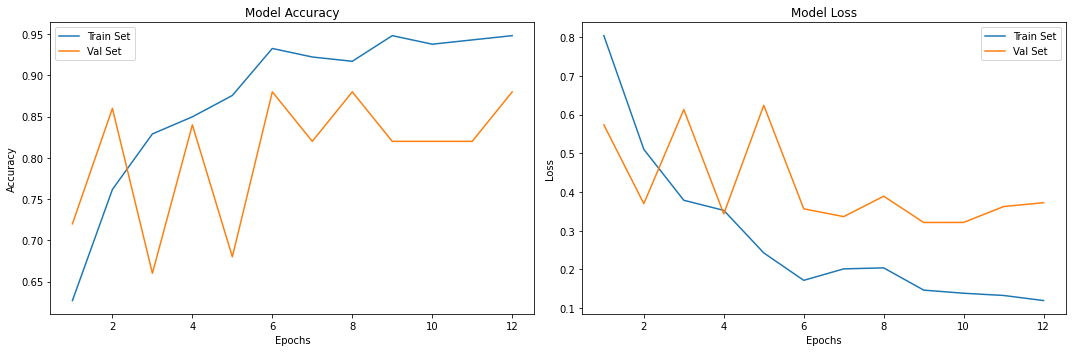

In [85]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

## Validate on val set

Val Accuracy = 0.86


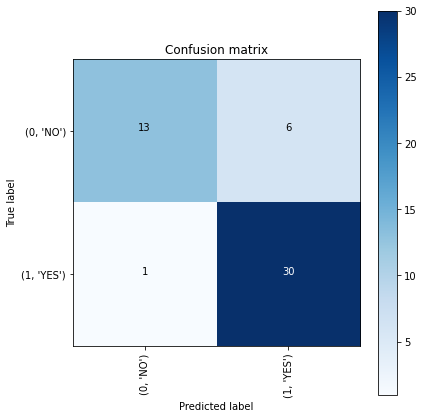

Test Accuracy = 0.90


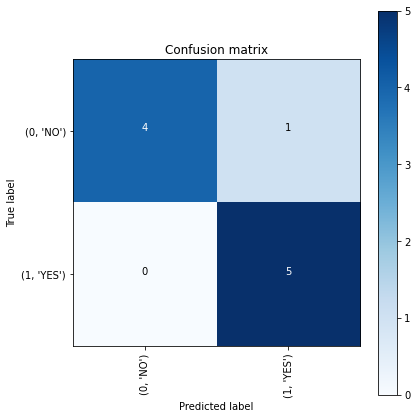

In [86]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)